# Create the Timeseries Dataset

In the first 2 Notebooks, data are collected and anonymized. The 01-data_structures Notebooks collected all csv files and prepare data for

- anonymization
- generate the TimeSeries Dataset

## Anonymized files

- final_document_indicator.csv
- final_flows.csv
- final_funds_fees.csv
- final_funds_scope.csv
- final_managers_experience.csv
- final_performances.csv
- final_psu_scoring_by_fund.csv
- final_events_impact.csv

### final_funds_scope
This is the pivot table. I choose to limit the scope to UCITS funds (follow some specific rules and protect the investor).

### final_flows
For each funds of the scope, this file contains flows (In/out) for last 10 years on a monthly frequency. The data are completed by the net quantity of shares exchanged

### final_performances
For each funds of the scope this files contains 10 years (monthly frequency) or data:
- performance (1, 3, 6 months and 1 year)
- benchmark performance (1, 3, 6 months and 1 year)
    - This indicated the markets trends
- analystics such as Volatility

### final_psu_scoring_by_fund
This file contains for each funds on a monthly basis for the last 10 years the score (PSU - Macro Research analyst). The score is evaluated on the country exposure of the funds and classified in region.

### final document indicator
This file contains for last 10 years on a monthly frequency the number of document and website (www.pictetfunds.com -> am.pictet.com) interaction. It shows the interest of visitor for funds.

### final_funds_fees
This file contains for each funds an indicator how much fees cost for investor.

### final_managers_experience
This file contains for each funds the experience of funds managers. This indicator will help to create a ranking in experience management.

### final_rfp
PAM has a dedicated team to answer request for proposal (RFP). When Sales pitch a mandate there is often a RFP document. It's a list of questions and answers give to the investor usefull information about the funds/mandate to make investment decision.

### final_events_impact
All client (investor) interactions are logged in SalesForce. With the help of the dedicated team, I extracted a list of events (conference, roadshow, webcast) from the system with 3 indicators: number of people invited, number who accepted and number who finally attended. The marketing have a ranking process to calculate the event <i>result</i> in term of participation. This computation has been applied to the exported data and group by month (year + month). It's quite rare to have an event explicitely dedicated to 1 fund. So the data will used to qualify the period (year + month) in term of event and will be used to calculate a linear effect on commings month after the event.

## Data Model
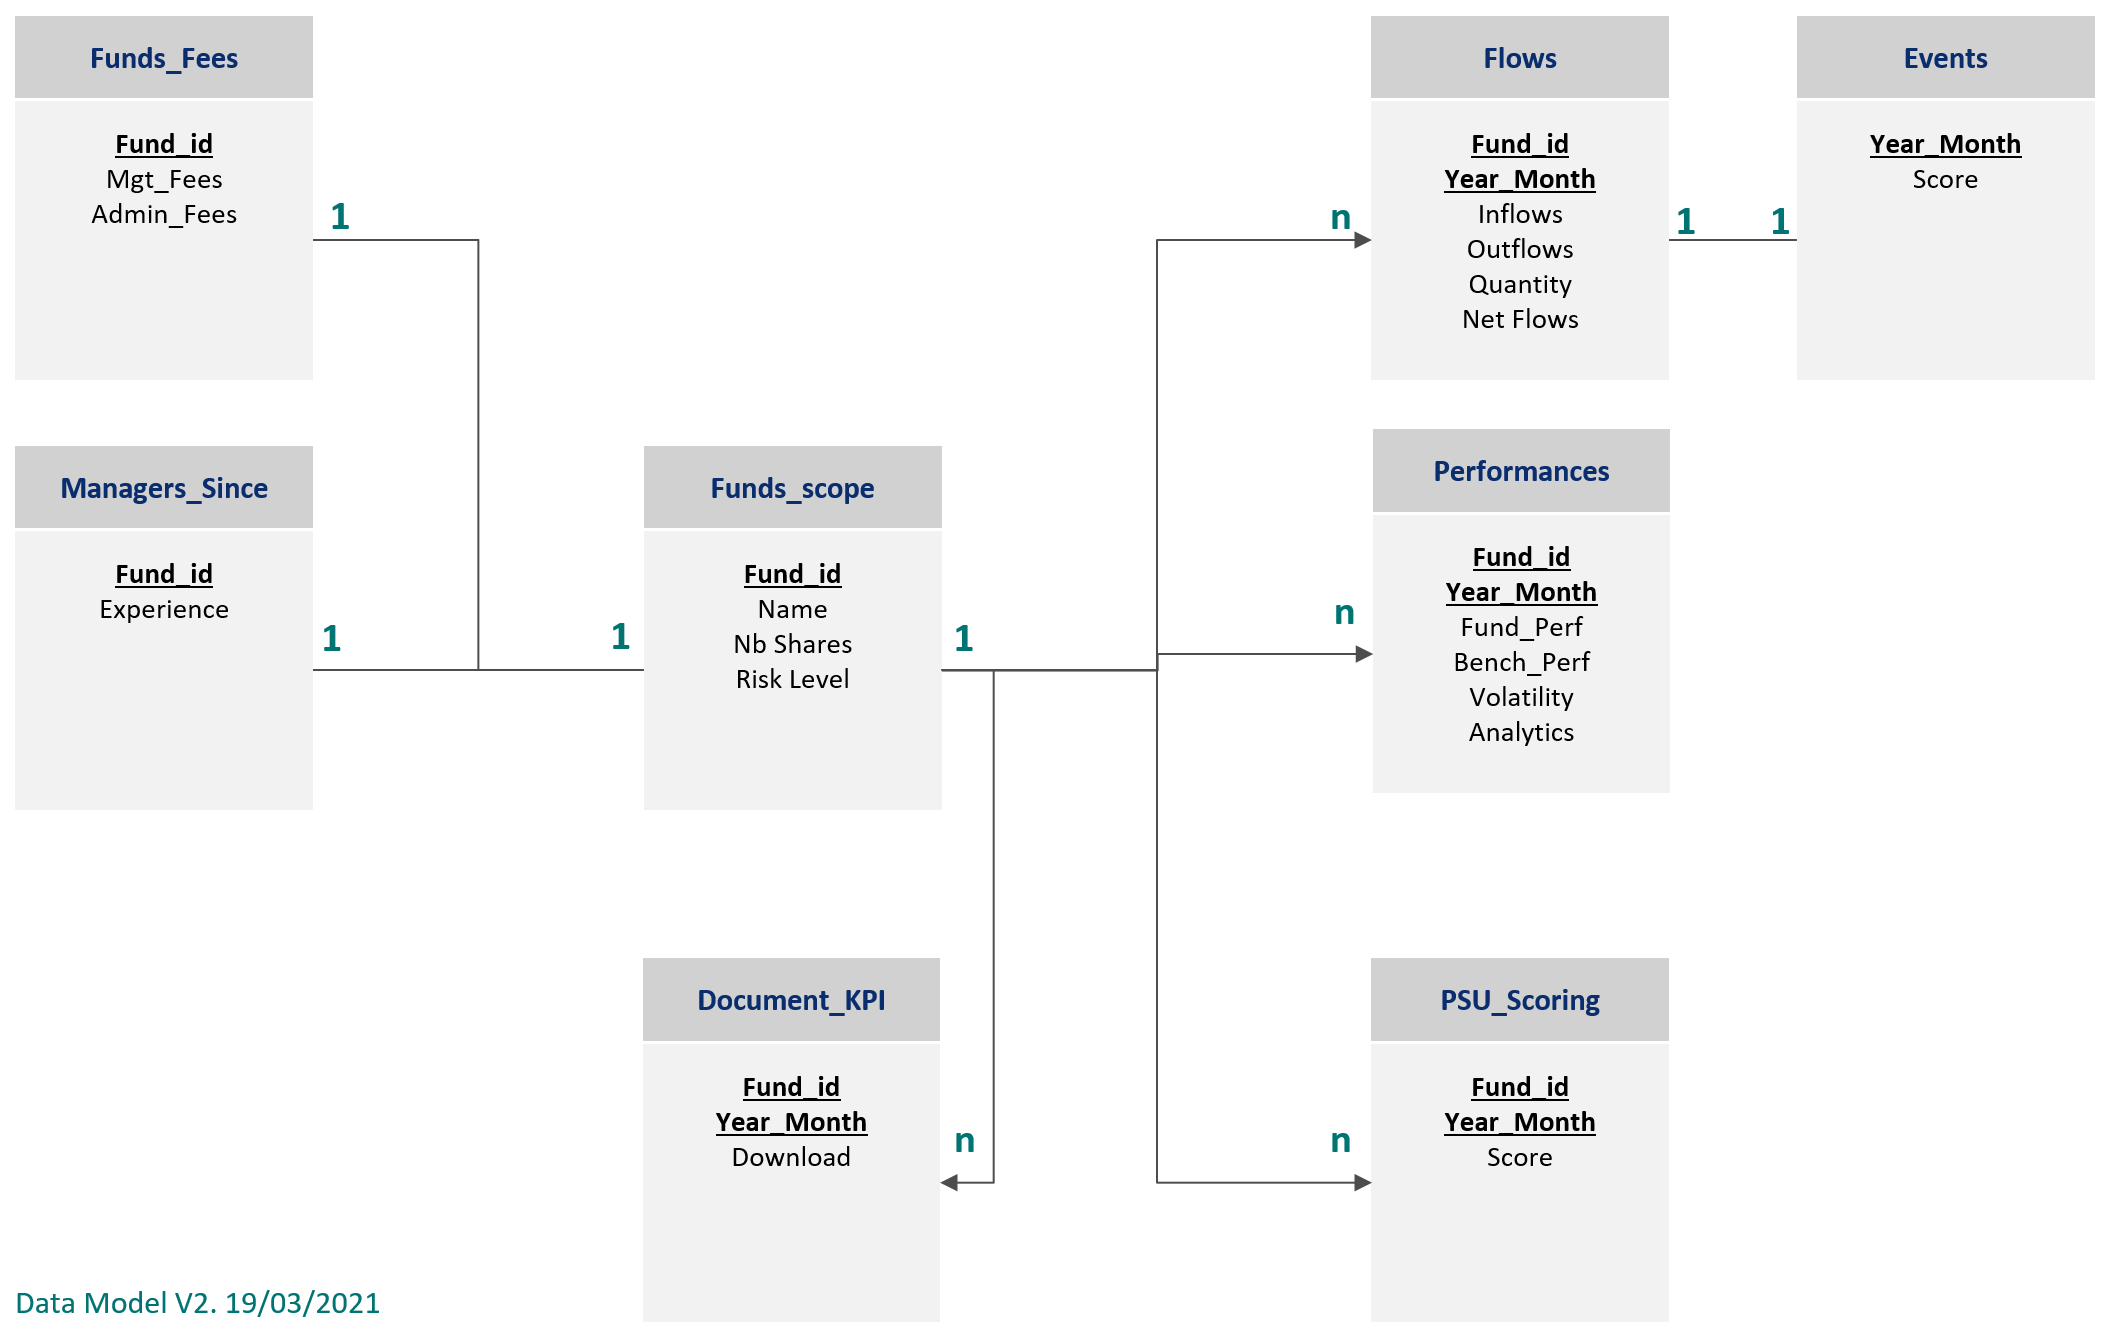

## Timeseries dataset creation methodology

I will concatente my different data sources files in a timeseries dataset.

The pivot file is the flows which contains the flows per period (year+month) and a fund key. Some data files will be joined on te fund key, some on the period (year+month) and the others on the fund key & the period. Depending on the source file, the merge will apply an <b>inner</b> join or sometimes a <b>left</b> join to keep th whole timeseries and add columns. Left join will will create NaN value which will be covered in the EDA of the timeseries before transformation to the final supervised learning problem.

At the en of the timeseries dataset creation I will create the target value by computing a score of the net flows Vs. the asset under management to qualify the labels (-1, 0, +1):
- (-1) negative flows with impact
- (0) neutral; negative or positive flows without deep impact; if net flows is smaller than x% of the AUM
- (+1) positive flows with impact


The TimeSeries dataset is created in the <b>ts</b> object and merged with source files loaded in a temporary dataset.

In [1]:
import pandas as pd
from datetime import datetime
# run of the notebooks are logged in the 00-runall.log files
# change the level to hide or show all warning, errors or comments
import logging

# create a file name
now = datetime.now()
filename = 'logs/03-create-TS-' + now.strftime('%m%d%Y%H%M%S') + '.log'


logging.basicConfig(filename=filename ,format='%(asctime)s | %(levelname)s: %(message)s', level=20)
logging.info('I start to run your Notebook ! -- Good Luck :-) ')

# declare the source (anonimized) forlder
folder = '_anonymized/'

## Flows

In [2]:
# read the csv file
flows = pd.read_csv(folder+'final_flows.csv')

# drop useless columns and rename a few
flows.drop(['Unnamed: 0','Unnamed: 0.1'], axis=1, inplace=True)
flows.rename(columns={'Asset Name':'ASSET_NAME','Product Strategy':'PRODUCT_STRATEGY','Quantity':'QUANTITY'}, inplace=True)

# reorder columns to have primary & foreign key on the left
# transform EOM (End of Month) in datetim object
flows = flows[['SRC_UID','EOM','ASSET_NAME','PRODUCT_STRATEGY','QUANTITY','IN (USD)','OUT (USD)','NET (USD)','AUM (USD)']]
flows['EOM']=pd.to_datetime(flows['EOM'])


# the source file might contains duplicate rows with flows for the same date
# the reason is a fund can be promoted with 2 or more strategies
agg = {'QUANTITY':'sum','IN (USD)':'sum','OUT (USD)':'sum','NET (USD)':'sum','AUM (USD)':'sum','ASSET_NAME':'first','PRODUCT_STRATEGY':'first'}
flows = flows.groupby(['SRC_UID','EOM']).agg(agg).reset_index()

logging.info('Number of flows {} read from the source file with {} columns. After combining duplicates.'
             .format(flows.shape[0], flows.shape[1]) )
flows.shape

(14820, 9)

In [3]:
# display sample lines
flows.sample(8)

,SRC_UID,EOM,QUANTITY,IN (USD),OUT (USD),NET (USD),AUM (USD),ASSET_NAME,PRODUCT_STRATEGY
3891,323418458,2012-05-31,632831,42525561,-23518440,19007121,294452820,Isoodon obesulus,Limnocorax flavirostra
9820,880880278933,2013-05-31,5890937,31349189,-54809480,-23460291,623373737,Chlidonias leucopterus,Ara chloroptera
1970,206670721,2018-09-30,13656615,90185709,-241097997,-150912287,3618483596,Bassariscus astutus,Gyps bengalensis
11926,186761292782742,2018-11-30,756965,15802148,-2004239,13797910,128620801,Dendrocygna viduata,Galago crassicaudataus
10072,880888590812,2012-04-30,4248285,17269132,-69043758,-51774626,576738075,Alopex lagopus,Alcelaphus buselaphus caama
637,206670692,2018-06-30,1574959,14998129,-17360827,-2362697,180133962,Merops nubicus,Hymenolaimus malacorhynchus
9087,573917296406,2013-04-30,120043,587322,-1141749,-554427,19513025,Passer domesticus,Phascogale calura
91,206670686,2017-08-31,25326940,89261018,-36580106,52680911,2461938289,Lamprotornis nitens,Galago crassicaudataus


## Performances

In [4]:
performances = pd.read_csv(folder+'final_performances.csv')

# delete useless columns
performances.drop(['Unnamed: 0','COLL_INV_SHARE_ID'], axis=1, inplace=True)

# transform the EOM
performances['EOM']=pd.to_datetime(performances['EOM'])
logging.info('Number of returns {} read from the source file with {} columns.'
             .format(performances.shape[0], performances.shape[1]) )
performances.shape

(14762, 24)

In [5]:
performances.head()

,SRC_UID,EOM,BENCH_PERF_1_MONTH,BENCH_PERF_1_YEAR,BENCH_PERF_3_MONTH,BENCH_PERF_6_MONTH,BENCH_VOL_1_MONTH,BENCH_VOL_3_MONTH,BENCH_VOL_6_MONTH,BENCH_VOLATILITY_1_YEAR,...,NAV_VOL_1_MONTH,NAV_VOL_3_MONTH,NAV_VOL_6_MONTH,NAV_VOLATILITY_1_YEAR,BENCH_VOL_SINCE_INCEPT,NAV_PERF_COMPOUND_CREATION,NAV_VOL_SINCE_INCEPT,FUND_SIZE,SUB_FUNDS_SHARE_PARTS,SUB_FUNDS_SHARE_SIZE_SF_CCY
0,206670686,2010-01-31,0.014942,0.113286,0.032765,-0.015738,NaN,0.245469,0.211980,0.223511,...,NaN,0.212784,0.182292,0.208115,0.170122,-0.053565,0.188558,3.616639e+09,205824.045939,NaN
1,206670686,2010-02-28,0.009174,0.216422,0.094813,-0.028279,NaN,0.162005,0.201205,0.210998,...,NaN,0.148753,0.182231,0.187907,0.169895,-0.050507,0.187964,3.550572e+09,204015.361237,NaN
2,206670686,2010-03-31,0.084779,0.305164,0.110608,0.101426,0.132895,0.139081,0.144440,0.162225,...,0.114328,0.136174,0.141438,0.162507,0.171529,-0.034185,0.189402,4.081723e+09,212212.447970,NaN
3,206670686,2010-04-30,0.013376,0.218337,0.108930,0.145395,NaN,0.101500,0.182932,0.147979,...,NaN,0.092254,0.159751,0.147225,0.170457,-0.029439,0.188317,4.305273e+09,218549.055747,NaN
4,206670686,2010-05-31,-0.062429,0.085090,0.029677,0.128779,NaN,0.173355,0.175834,0.166273,...,NaN,0.189736,0.169677,0.168318,0.171839,-0.037850,0.189286,3.540400e+09,201417.701021,NaN


### Merge Flows and performances on SRC_UID + EOM
Method applied: inner join to be sure to have performances fro flows rows.

In [6]:
ts = flows.copy()
ts = ts.sort_values(['SRC_UID','EOM'])
ts = ts.merge(performances, left_on=['SRC_UID','EOM'], right_on=['SRC_UID','EOM'], how='inner')
# log
logging.info('Merge Flows and performances on SRC_UID + EOM. Method = inner to keep only joined rows.')
logging.info('Number of merged rows {} read from the source file with {} columns.'
             .format(ts.shape[0], ts.shape[1]) )

In [7]:
ts.shape

(14641, 31)

In [8]:
ts.head()

,SRC_UID,EOM,QUANTITY,IN (USD),OUT (USD),NET (USD),AUM (USD),ASSET_NAME,PRODUCT_STRATEGY,BENCH_PERF_1_MONTH,...,NAV_VOL_1_MONTH,NAV_VOL_3_MONTH,NAV_VOL_6_MONTH,NAV_VOLATILITY_1_YEAR,BENCH_VOL_SINCE_INCEPT,NAV_PERF_COMPOUND_CREATION,NAV_VOL_SINCE_INCEPT,FUND_SIZE,SUB_FUNDS_SHARE_PARTS,SUB_FUNDS_SHARE_SIZE_SF_CCY
0,206670686,2010-01-31,1436873,4368774,-2405147,1963627,69213144,Lamprotornis nitens,Himantopus himantopus,0.014942,...,NaN,0.212784,0.182292,0.208115,0.170122,-0.053565,0.188558,3.616639e+09,205824.045939,NaN
1,206670686,2010-02-28,1424911,5049992,-5634350,-584358,69316411,Lamprotornis nitens,Himantopus himantopus,0.009174,...,NaN,0.148753,0.182231,0.187907,0.169895,-0.050507,0.187964,3.550572e+09,204015.361237,NaN
2,206670686,2010-03-31,1483169,6004865,-3088212,2916654,75959198,Lamprotornis nitens,Himantopus himantopus,0.084779,...,0.114328,0.136174,0.141438,0.162507,0.171529,-0.034185,0.189402,4.081723e+09,212212.447970,NaN
3,206670686,2010-04-30,1533816,5292849,-2495553,2797296,79769858,Lamprotornis nitens,Himantopus himantopus,0.013376,...,NaN,0.092254,0.159751,0.147225,0.170457,-0.029439,0.188317,4.305273e+09,218549.055747,NaN
4,206670686,2010-05-31,1411918,2990326,-9334102,-6343775,67598280,Lamprotornis nitens,Himantopus himantopus,-0.062429,...,NaN,0.189736,0.169677,0.168318,0.171839,-0.037850,0.189286,3.540400e+09,201417.701021,NaN


## Documents Download KPI

In [9]:
# load files
documents = pd.read_csv(folder+'final_document_indicator.csv')

# delete useless columns
documents.drop(['Unnamed: 0','Unnamed: 0.1','FUND'], axis=1, inplace=True)
documents=documents[['SRC_UID','EOM','CNT']]
documents['EOM']=pd.to_datetime(documents['EOM'])

# the file contains multiple row for a same fund and same date (EOM) - data was extracted as the document type level
# I compute the sum of document downloaded
documents=documents.groupby(['SRC_UID','EOM']).sum().reset_index()
logging.info('Number of documents rows {} read from the source file with {} columns.'
             .format(documents.shape[0], documents.shape[1]) )

In [10]:
documents.sample(8)

,SRC_UID,EOM,CNT
3915,38679964783,2012-05-31,8
8839,188703102004066,2014-09-30,1803
7448,880880278933,2018-11-30,725
1694,206670746,2011-05-31,133
1417,206670734,2019-10-31,583
8231,1540205459539,2016-03-31,34
981,206670721,2012-12-31,2402
6594,537115818972,2013-11-30,16670


In [11]:
ts=ts.merge(documents, left_on=['SRC_UID','EOM'], right_on=['SRC_UID','EOM'], how='left')
logging.info('Merge time series (ts) with documents. Method applied is left-join to keep the full ts.')
ts.shape

(14641, 32)

In [12]:
try:
    ts.rename({'CNT':'DOWNLOADED_DOCUMENTS'},axis=1, inplace=True)
except:
    None
    
ts.sample(8)

,SRC_UID,EOM,QUANTITY,IN (USD),OUT (USD),NET (USD),AUM (USD),ASSET_NAME,PRODUCT_STRATEGY,BENCH_PERF_1_MONTH,...,NAV_VOL_3_MONTH,NAV_VOL_6_MONTH,NAV_VOLATILITY_1_YEAR,BENCH_VOL_SINCE_INCEPT,NAV_PERF_COMPOUND_CREATION,NAV_VOL_SINCE_INCEPT,FUND_SIZE,SUB_FUNDS_SHARE_PARTS,SUB_FUNDS_SHARE_SIZE_SF_CCY,DOWNLOADED_DOCUMENTS
1250,206670710,2014-04-30,186569,3830846,-7599649,-3768803,461003585,Anthropoides paradisea,Tadorna tadorna,0.016035,...,0.104506,0.116425,0.070237,0.130097,0.073198,0.144971,4.060627e+08,6.221615e+04,1.353542e+08,NaN
6959,108392941183,2010-01-31,3256284,14166592,-38517246,-24350654,507274562,Anas platyrhynchos,Cyrtodactylus louisiadensis,0.000416,...,0.000294,0.000366,NaN,0.003080,0.025381,0.002933,3.903230e+08,8.701048e+05,NaN,NaN
14377,210435370127300,2019-09-30,1439630,2192184,-7440065,-5247881,152932809,Tachybaptus ruficollis,Psophia viridis,0.037627,...,0.045285,0.040417,0.037956,0.109830,-0.007651,0.033118,1.402730e+08,4.798768e+05,4.675766e+07,372.0
2463,206670739,2015-08-31,10364643,59974046,-27954306,32019740,1540769548,Mellivora capensis,Ara chloroptera,-0.060109,...,0.268339,0.198771,0.161849,0.130401,0.075049,0.130313,1.483491e+09,2.579887e+06,3.708727e+08,144.0
13194,192291882972375,2017-05-31,13162883,178521128,-29881150,148639978,1425867193,Genetta genetta,Herpestes javanicus,0.005411,...,0.033934,0.032311,0.052192,0.049252,0.040057,0.056881,1.425942e+09,7.313318e+05,7.921899e+07,1468.0
3231,218465821,2013-01-31,4592268,784547259,-808542535,-23995500,4842069377,Dromaeus novaehollandiae,Galago crassicaudataus,-0.000345,...,0.000120,0.000164,0.000515,0.002665,0.007566,0.002462,4.433833e+09,1.154613e+06,1.108458e+09,NaN
6490,108207596093,2012-02-29,57582,1846726,-2476416,-629690,59071674,Isoodon obesulus,Cyrtodactylus louisiadensis,0.000516,...,0.001720,0.001520,0.002099,0.006260,0.020546,0.006230,5.907160e+07,1.919407e+04,1.969053e+07,132.0
10761,1676124906944,2018-11-30,6048740,5404414,-10255983,-4851569,720038464,Varanus sp.,Herpestes javanicus,NaN,...,0.073419,0.080616,0.079569,NaN,0.011181,0.157083,8.608089e+08,6.019436e+05,7.173407e+07,1200.0


In [13]:
ts.dtypes

SRC_UID                                 int64
EOM                            datetime64[ns]
QUANTITY                                int64
IN (USD)                                int64
OUT (USD)                               int64
NET (USD)                               int64
AUM (USD)                               int64
ASSET_NAME                             object
PRODUCT_STRATEGY                       object
BENCH_PERF_1_MONTH                    float64
BENCH_PERF_1_YEAR                     float64
BENCH_PERF_3_MONTH                    float64
BENCH_PERF_6_MONTH                    float64
BENCH_VOL_1_MONTH                     float64
BENCH_VOL_3_MONTH                     float64
BENCH_VOL_6_MONTH                     float64
BENCH_VOLATILITY_1_YEAR               float64
NAV_PERF_1_MONTH                      float64
NAV_PERF_1_YEAR                       float64
NAV_PERF_3_MONTH                      float64
NAV_PERF_6_MONTH                      float64
NAV_VOL_1_MONTH                   

## PSU Scoring (Macro Research)

In [14]:
psu = pd.read_csv(folder+'final_psu_scoring_by_fund.csv')
psu.drop('Unnamed: 0', axis=1, inplace=True)
psu['EOM']=pd.to_datetime(psu['EOM'])

# prepare aggreate setup fro group by method as the file doesn't contain unique value
agg={'WEIGHTED':'max','COUNTRY':'first','PSU':'first','PSU_SCORE':'max'}

# I may have some duplicates line in the source file, so I decided to take
# the max of the value and the last country/zone
psu = psu.groupby(['SRC_UID','EOM']).agg(agg).reset_index()
logging.info('Number of PSU rows {} read from the source file with {} columns.'.format(psu.shape[0], psu.shape[1]) )
psu.shape

(9155, 6)

In [15]:
psu.sample(8)

,SRC_UID,EOM,WEIGHTED,COUNTRY,PSU,PSU_SCORE
292,206670694,2017-10-31,0.5904,U.S.A.,US,3.0
5450,437983596250,2012-08-31,0.9600,SWITZERLAND,Switzerland,1.0
5010,272675524722,2011-07-31,0.3440,U.S.A.,US,1.0
8507,195667467951412,2018-11-30,0.1350,U.S.A.,US,3.0
5136,369592842106,2010-12-31,0.5060,U.S.A.,US,3.0
6834,1521081543045,2010-07-31,0.2840,SAUDI ARABIA,EMEA,3.0
5221,369592842106,2018-01-31,0.6107,U.S.A.,US,4.0
2585,28283084613,2015-01-31,0.3934,CHINA,China,3.0


Merge the timeseries (ts) with the PSU dataset by applying a left join. Some line will have NaN as PSU_SCORE because no criteria was found. The missing value will be covered in the EDA step of the timeseries.

In [16]:
ts=ts.merge(psu, left_on=['SRC_UID','EOM'], right_on=['SRC_UID','EOM'], how='left')
logging.info('Merge the PSU table with Time Series (ts). Method = left to keep all ts rows.')
ts.shape

(14641, 36)

In [17]:
ts.sample(8)

,SRC_UID,EOM,QUANTITY,IN (USD),OUT (USD),NET (USD),AUM (USD),ASSET_NAME,PRODUCT_STRATEGY,BENCH_PERF_1_MONTH,...,NAV_PERF_COMPOUND_CREATION,NAV_VOL_SINCE_INCEPT,FUND_SIZE,SUB_FUNDS_SHARE_PARTS,SUB_FUNDS_SHARE_SIZE_SF_CCY,DOWNLOADED_DOCUMENTS,WEIGHTED,COUNTRY,PSU,PSU_SCORE
5069,38326395382,2014-09-30,2139175,24306619,-7063514,17243105,267312460,Myrmecophaga tridactyla,Ara chloroptera,-0.000673,...,0.020118,0.012669,2.804282e+08,4.481887e+05,5.608565e+07,NaN,0.6433,U.S.A.,US,4.0
2149,206670723,2011-08-31,15104224,27826313,-96810972,-68984659,3039979100,Melophus lathami,Coluber constrictor,-0.072449,...,0.046357,0.155876,2.263289e+09,1.258432e+06,1.760329e+08,3696.0,0.4350,U.S.A.,US,4.0
4839,28283084613,2017-09-30,332759,6244343,-2865801,3378542,182845254,Butorides striatus,Ara chloroptera,-0.006140,...,0.110029,0.199325,1.829480e+08,3.028477e+04,1.663163e+07,2033.0,0.5616,CHINA,China,4.0
1300,206670710,2018-06-30,122632,4854035,-9645166,-4791131,346030802,Anthropoides paradisea,Tadorna tadorna,0.015988,...,0.072763,0.139111,3.435278e+08,4.086979e+04,1.145093e+08,NaN,NaN,NaN,NaN,NaN
10996,185770864373177,2016-04-30,1163389,1108517,-3995138,-2886621,171159273,Ovibos moschatus,Anathana ellioti,0.038425,...,0.052030,0.057048,1.711603e+08,1.292655e+05,1.901782e+07,NaN,NaN,NaN,NaN,NaN
4194,455157311,2019-05-31,286650,58834154,-43679944,15154210,365071470,Ursus maritimus,Ara chloroptera,0.000595,...,0.015442,0.003990,2.990117e+08,7.397787e+04,7.475293e+07,2050.0,0.1856,FRANCE,Eurozone,2.0
4212,455157311,2020-11-30,304771,24682043,-138388115,-113706072,410847220,Ursus maritimus,Ara chloroptera,0.000041,...,0.012589,0.003189,3.270872e+08,8.098127e+04,8.177180e+07,367.0,0.1696,SWITZERLAND,Switzerland,4.0
8488,409803252816,2010-01-31,941478,13450711,-14137731,-687020,127620513,Loxodonta africana,Coluber constrictor,0.000280,...,-0.012924,0.025352,9.649400e+07,1.977559e+05,NaN,NaN,NaN,NaN,NaN,NaN


## Managers

In [18]:
managers = pd.read_csv(folder+'final_managers_experience.csv')
managers.drop(['Unnamed: 0'], axis=1, inplace=True)
managers=managers[['SRC_UID','EXPERIENCE']]
logging.info('Number of managers rows {} read from the source file with {} columns.'
             .format(managers.shape[0], managers.shape[1]) )

managers.shape

(88, 2)

In [19]:
managers.sample(8)

,SRC_UID,EXPERIENCE
45,656760542396,793.535442
5,880923451687,3384.255271
33,52079200642,1507.168775
6,206670715,2842.147465
73,189669225079108,1289.894303
54,186761292782742,1253.227636
56,1451747082532,2371.188605
41,206670686,3289.329744


Merge the managers experience in the timeseries with a left join method. Missing value will be covered in EDA.

In [20]:
ts = ts.merge(managers, left_on='SRC_UID', right_on='SRC_UID', how='left')
logging.info('Merge the managers table with the time series. Keep all time series rows and join manager experience')
ts.shape

(14641, 37)

In [21]:
ts.sample(8)

,SRC_UID,EOM,QUANTITY,IN (USD),OUT (USD),NET (USD),AUM (USD),ASSET_NAME,PRODUCT_STRATEGY,BENCH_PERF_1_MONTH,...,NAV_VOL_SINCE_INCEPT,FUND_SIZE,SUB_FUNDS_SHARE_PARTS,SUB_FUNDS_SHARE_SIZE_SF_CCY,DOWNLOADED_DOCUMENTS,WEIGHTED,COUNTRY,PSU,PSU_SCORE,EXPERIENCE
1853,206670719,2020-03-31,716661,4025637,-1661642,2363995,117498979,Chlidonias leucopterus,Ictonyx striatus,-0.048598,...,0.121109,1.136924e+08,238902.537167,3.789748e+07,NaN,0.9783,SWITZERLAND,Switzerland,1.0,NaN
4374,1489764652,2012-03-31,5897809,48868516,-13212687,35655829,628143750,Nasua narica,Galago crassicaudataus,0.024912,...,0.181486,3.123489e+10,590445.478938,5.175641e+09,1555.0,NaN,NaN,NaN,NaN,1300.202108
9689,880880278933,2014-06-30,2269387,5536631,-5759933,-223302,237095988,Chlidonias leucopterus,Phascogale calura,0.000411,...,0.076162,2.375183e+08,151538.539344,1.583455e+07,NaN,NaN,NaN,NaN,NaN,804.502109
9058,638750702637,2014-07-31,2691019,20874711,-32159468,-11284757,152921808,Cordylus giganteus,Pelecans onocratalus,-0.062197,...,0.387567,1.286229e+08,268619.301210,1.526359e+07,4059.0,0.9805,RUSSIA,World,4.0,1939.945357
14034,203907422523400,2016-05-31,890000,0,0,0,89640800,Ara ararauna,Bubo virginianus,0.000342,...,0.034214,8.963774e+07,890000.000000,8.963774e+07,NaN,NaN,NaN,NaN,NaN,NaN
4243,1461078666,2012-05-31,677536,691195,-6001451,-5310255,112089817,Macropus giganteus,Ara chloroptera,-0.060758,...,0.160373,9.061356e+07,135449.036814,1.812271e+07,NaN,0.2710,UNITED KINGDOM,UK,3.0,674.617721
10028,880923451687,2017-04-30,5114812,11994820,-20250623,-8255803,559741131,unavailable,Cyrtodactylus louisiadensis,-0.000609,...,0.002540,5.152442e+08,854509.368130,8.587403e+07,1027.0,NaN,NaN,NaN,NaN,3384.255271
13435,195788173009015,2015-07-31,2110441,17740248,-7625673,10114575,240612861,Vanellus armatus,unavailable,0.002350,...,0.007766,3.175391e+09,205858.941585,2.128011e+07,NaN,0.1602,U.S.A.,US,4.0,NaN


## Funds Fees & Funds details

In [22]:
funds_fees = pd.read_csv(folder+'final_funds_fees.csv')
funds_fees.drop(['Unnamed: 0','Unnamed: 0_x', 'Unnamed: 0_y','NAME'], axis=1, inplace=True)
logging.info('Number of feews rows {} read from the source file with {} columns.'
             .format(funds_fees.shape[0], funds_fees.shape[1]) )


# eliminates duplicates
funds_fees = funds_fees.drop_duplicates(subset=['SRC_UID'], keep='first')
funds_fees.shape

(81, 11)

In [23]:
funds_fees.sample(8)

,FUND_NAME,ADMINSTRATION_FEES,MANAGEMENT_FEES,MULTI_MANAGER_STRUCTURE,SOFTCLOSING,SRC_UID,RISK_LEVEL,DATE_SHARE,CNT_SHARE,Strategy Capability,Capability IS Strategic
32,Actophilornis africanus,0.001673,0.009033,1,0.0,324918516,Moderate / high risk,27.09.2001,25,Credit,No
91,Felis concolor,0.000300,0.001500,0,0.0,206670739,Moderate / high risk,13.03.2000,6,Indexed Equities,No
60,Cordylus giganteus,0.000300,0.007167,0,0.0,40234253942,Low / moderate risk,06.11.2003,5,Multi Asset,Yes
72,Trachyphonus vaillantii,0.001658,0.008579,1,0.0,192290937586348,Moderate / high risk,30.11.2012,31,Active Quant,No
52,Ardea cinerea,0.002347,0.012600,1,0.0,63446153971,High risk,30.06.2004,15,Thematic,Yes
96,Myrmecobius fasciatus,0.002412,0.012529,1,1.0,206670723,High risk,19.01.2000,19,Thematic,Yes
76,Hymenolaimus malacorhynchus,0.002412,0.012529,1,1.0,207934051132,High risk,31.10.2006,18,Thematic,Yes
47,Tamandua tetradactyla,0.001000,0.004667,1,0.0,189669396589741,High risk,30.03.2012,16,Active Quant,No


I will merge funds_fees dataset to ts with an inner join method to keep rows from the timeseries which are in the scope of funds that I will covered in the project (~90 funds). This should give as result a timeseries (ts) dataset of 10k entries.

In [24]:
ts = ts.merge(funds_fees, how='inner', left_on='SRC_UID', right_on='SRC_UID')
logging.info('Merge te fees table with the time series. Funds has a unique fees. Those without fees will be aligned with an average of the strategy in EDA')
ts.shape

(9891, 47)

In [25]:
ts.sample(8)

,SRC_UID,EOM,QUANTITY,IN (USD),OUT (USD),NET (USD),AUM (USD),ASSET_NAME,PRODUCT_STRATEGY,BENCH_PERF_1_MONTH,...,FUND_NAME,ADMINSTRATION_FEES,MANAGEMENT_FEES,MULTI_MANAGER_STRUCTURE,SOFTCLOSING,RISK_LEVEL,DATE_SHARE,CNT_SHARE,Strategy Capability,Capability IS Strategic
1178,206670721,2019-07-31,9279152,24066227,-118055681,-93989454,2529001979,Bassariscus astutus,Galago crassicaudataus,0.022603,...,Myiarchus tuberculifer,0.000805,0.002460,1,0.0,Moderate / high risk,13.10.1999,24,Indexed Equities,No
5158,108202450315,2010-05-31,407004,89667289,-93743568,-4076279,507527069,Gyps bengalensis,Cyrtodactylus louisiadensis,0.000199,...,Choloepus hoffmani,0.000300,0.001320,0,0.0,Low risk,23.06.2005,5,Money Market,No
8130,186759829869822,2018-11-30,4211659,36829621,-19719044,17110576,860986232,Plegadis ridgwayi,Ara chloroptera,0.013981,...,Haematopus ater,0.002241,0.010219,1,0.0,High risk,10.09.2010,37,Thematic,Yes
5075,108193333943,2013-10-31,323532,16539912,-13006387,3533525,348966335,Ara ararauna,Galago crassicaudataus,-0.000034,...,Crotalus cerastes,0.000300,0.000980,0,0.0,Low risk,23.06.2005,5,Money Market,No
4674,55902523917,2013-06-30,4642629,10875314,-53781920,-42906606,1089909261,unavailable,Ara chloroptera,-0.064230,...,Panthera pardus,0.000687,0.002947,1,0.0,High risk,19.03.2004,15,Emerging Markets,Yes
6551,656760542396,2016-11-30,2630955,14622069,-27406909,-12784840,381455017,Centrocercus urophasianus,Ateles paniscus,0.014097,...,Tauraco porphyrelophus,0.002287,0.012067,1,0.0,High risk,29.09.2008,17,Thematic,Yes
7392,1676124906944,2010-04-30,2438609,23333591,-13866436,9467154,287425985,Varanus sp.,Pycnonotus nigricans,NaN,...,Madoqua kirkii,0.000229,0.002229,0,0.0,Moderate / high risk,30.09.2009,14,Alternatives,No
6575,656760542396,2018-11-30,3449986,16634861,-115943644,-99308783,558240319,Centrocercus urophasianus,Ara chloroptera,0.014192,...,Tauraco porphyrelophus,0.002287,0.012067,1,0.0,High risk,29.09.2008,17,Thematic,Yes


In [26]:
d = {'Strategy Capability':'STRATEGY_CAPABILITY','Capability IS Strategic':'IS_STRATEGIC'}
ts.rename(d, axis=1, inplace=True)

## RFP data
The data will be merged on SRC_UID and EOM after dealing with duplicates in RFP files if any.

In [27]:
rfp = pd.read_csv(folder+'final_rfp_indicators.csv')
try:
    cols = ['Creation Date','Product Type','RFP ID','NAME','Unnamed: 0']
    rfp.drop(cols, axis=1, inplace=True)
except:
    logging.warning('rfp dataset - columns Unnamed: 0 already dropped')

rfp.rename({'Status':'RFP_STATUS'}, axis=1, inplace=True)


# only keep rfp lines won or in progress
f1=rfp['RFP_STATUS']=='Rejected'
f2=rfp['RFP_STATUS']=='Lost'
rfp = rfp[(~f1 & ~f2)].copy()
rfp['POSITIVE_RFP']=True
rfp['EOM'] = pd.to_datetime(rfp['EOM'])
rfp.drop_duplicates(subset=['SRC_UID','EOM','POSITIVE_RFP'],inplace=True)
rfp.sample(8)

,RFP_STATUS,EOM,SRC_UID,POSITIVE_RFP
2647,In progress,2015-01-31,1134069654772,True
3697,Done,2017-04-30,638750702637,True
3064,Completed,2015-05-31,181703187068,True
4771,Completed,2015-07-31,272675524722,True
6824,Completed,2016-12-31,275505523,True
4071,Completed,2014-12-31,880923451687,True
901,Done,2020-12-31,189669305873243,True
6879,Completed,2013-02-28,573917296406,True


In [28]:
rfp.dtypes

RFP_STATUS              object
EOM             datetime64[ns]
SRC_UID                  int64
POSITIVE_RFP              bool
dtype: object

The merge to the timeseries (ts) dataset will add a column (True or Nan) indicating that there if this period a interest from investor The EDA will determine how the effect of the interest must be allocated (a linearity can be apply to the commings month after the RFP).

In [29]:
ts = ts.merge(rfp[['SRC_UID','EOM','POSITIVE_RFP']], left_on=['SRC_UID','EOM'], right_on=['SRC_UID','EOM'], how='left')

In [30]:
ts.shape

(9891, 48)

## Event Indicators

The event indicator has been calculated on the number of event per month and a ratio between invited, accepted and attended people.

The value will be merged on the Dataset series per month.

Months with Nan values will be replaced with the mean of "months" because Events are extremly seasonable issue.

In [31]:
# load the event indicators files
events = pd.read_csv(folder+'final_events_impact.csv')

In [32]:
try:
    events.drop('Unnamed: 0', axis=1, inplace=True)
except:
    None

events['EOM']=pd.to_datetime(events['EOM'])
events.sample(8)

,EOM,EVENT_IMPACT
42,2018-04-30,3.463415
32,2017-06-30,6.815163
23,2016-09-30,8.769717
14,2015-12-31,4.435193
51,2019-01-31,7.371499
52,2019-02-28,10.924973
22,2016-08-31,8.251295
1,2011-01-31,1.000000


As the events indicator is a rank (number) for a specific period, the value will be added as a new column in the timeseries dataset. Missing value (no rank for a specifi month) will be coded with NaN and I will covered missing value in the timeseries EDA.

In [33]:
ts = ts.merge(events, left_on='EOM', right_on='EOM', how='left')
logging.info('Merge the events indicators table with the time series.')
ts.shape

(9891, 49)

### All sources files have been loaded, cleaned (columns) and merged with different join method in the (ts) timeseries datatset.

Perform a few checks and save the dataset for the next step.

In [34]:
# print null values and columns names
ts.isnull().sum()

SRC_UID                           0
EOM                               0
QUANTITY                          0
IN (USD)                          0
OUT (USD)                         0
NET (USD)                         0
AUM (USD)                         0
ASSET_NAME                        0
PRODUCT_STRATEGY                  0
BENCH_PERF_1_MONTH              421
BENCH_PERF_1_YEAR               691
BENCH_PERF_3_MONTH              469
BENCH_PERF_6_MONTH              541
BENCH_VOL_1_MONTH              2854
BENCH_VOL_3_MONTH               531
BENCH_VOL_6_MONTH               531
BENCH_VOLATILITY_1_YEAR         721
NAV_PERF_1_MONTH                 20
NAV_PERF_1_YEAR                 296
NAV_PERF_3_MONTH                 68
NAV_PERF_6_MONTH                142
NAV_VOL_1_MONTH                2535
NAV_VOL_3_MONTH                 132
NAV_VOL_6_MONTH                 134
NAV_VOLATILITY_1_YEAR           331
BENCH_VOL_SINCE_INCEPT          509
NAV_PERF_COMPOUND_CREATION      283
NAV_VOL_SINCE_INCEPT        

In [35]:
logging.info(ts.dtypes)

logging.info('COUNT NULL VALUES IN (ts)')
logging.info(ts.isnull().sum())


## Save the dataset
The (ts) dataset is a merged result of all source files (anonymized).
I save the dataset in a csv (and excel) file to be an input in the next Notebook.

In [36]:
# delete useless columns and reorder columns
try:
    ts.drop('Unnamed: 0', axis=1, inplace=True)
except:
    logging.warning('No columns to delete in (ts)')

# make some rename of columns for more easy manipulation
renamed_col = {'IN (USD)':'IN_FLOWS','OUT (USD)':'OUT_FLOWS','NET (USD)':'NET_FLOWS','AUM (USD)':'AUM'}
try:
    ts.rename(renamed_col, axis=1, inplace=True)
except:
    None
    
cols = ts.columns.tolist()
cols

['SRC_UID',
 'EOM',
 'QUANTITY',
 'IN_FLOWS',
 'OUT_FLOWS',
 'NET_FLOWS',
 'AUM',
 'ASSET_NAME',
 'PRODUCT_STRATEGY',
 'BENCH_PERF_1_MONTH',
 'BENCH_PERF_1_YEAR',
 'BENCH_PERF_3_MONTH',
 'BENCH_PERF_6_MONTH',
 'BENCH_VOL_1_MONTH',
 'BENCH_VOL_3_MONTH',
 'BENCH_VOL_6_MONTH',
 'BENCH_VOLATILITY_1_YEAR',
 'NAV_PERF_1_MONTH',
 'NAV_PERF_1_YEAR',
 'NAV_PERF_3_MONTH',
 'NAV_PERF_6_MONTH',
 'NAV_VOL_1_MONTH',
 'NAV_VOL_3_MONTH',
 'NAV_VOL_6_MONTH',
 'NAV_VOLATILITY_1_YEAR',
 'BENCH_VOL_SINCE_INCEPT',
 'NAV_PERF_COMPOUND_CREATION',
 'NAV_VOL_SINCE_INCEPT',
 'FUND_SIZE',
 'SUB_FUNDS_SHARE_PARTS',
 'SUB_FUNDS_SHARE_SIZE_SF_CCY',
 'DOWNLOADED_DOCUMENTS',
 'WEIGHTED',
 'COUNTRY',
 'PSU',
 'PSU_SCORE',
 'EXPERIENCE',
 'FUND_NAME',
 'ADMINSTRATION_FEES',
 'MANAGEMENT_FEES',
 'MULTI_MANAGER_STRUCTURE',
 'SOFTCLOSING',
 'RISK_LEVEL',
 'DATE_SHARE',
 'CNT_SHARE',
 'STRATEGY_CAPABILITY',
 'IS_STRATEGIC',
 'POSITIVE_RFP',
 'EVENT_IMPACT']

In [37]:
len(cols)

49

In [38]:
reorder_cols=['SRC_UID','PRODUCT_STRATEGY','ASSET_NAME','FUND_NAME',
              'STRATEGY_CAPABILITY','IS_STRATEGIC',
              'EOM','ADMINSTRATION_FEES',
 'MANAGEMENT_FEES',
 'MULTI_MANAGER_STRUCTURE', 'EXPERIENCE',
 'SOFTCLOSING',
 'RISK_LEVEL',
 'DATE_SHARE',
 'CNT_SHARE','QUANTITY',
 'IN_FLOWS',
 'OUT_FLOWS',
 'NET_FLOWS',
 'AUM',
 'BENCH_PERF_1_MONTH',
 'BENCH_PERF_1_YEAR',
 'BENCH_PERF_3_MONTH',
 'BENCH_PERF_6_MONTH',
 'BENCH_VOL_1_MONTH',
 'BENCH_VOL_3_MONTH',
 'BENCH_VOL_6_MONTH',
 'BENCH_VOLATILITY_1_YEAR',
 'NAV_PERF_1_MONTH',
 'NAV_PERF_1_YEAR',
 'NAV_PERF_3_MONTH',
 'NAV_PERF_6_MONTH',
 'NAV_VOL_1_MONTH',
 'NAV_VOL_3_MONTH',
 'NAV_VOL_6_MONTH',
 'NAV_VOLATILITY_1_YEAR',
 'BENCH_VOL_SINCE_INCEPT',
 'NAV_PERF_COMPOUND_CREATION',
 'NAV_VOL_SINCE_INCEPT',
 'FUND_SIZE',
 'SUB_FUNDS_SHARE_PARTS',
 'SUB_FUNDS_SHARE_SIZE_SF_CCY',
 'DOWNLOADED_DOCUMENTS',
 'WEIGHTED',
 'COUNTRY',
 'PSU',
 'PSU_SCORE','POSITIVE_RFP','EVENT_IMPACT']
len(reorder_cols)

49

In [39]:
ts = ts[reorder_cols]
ts.shape

(9891, 49)

In [40]:
ts.sample(8)

,SRC_UID,PRODUCT_STRATEGY,ASSET_NAME,FUND_NAME,STRATEGY_CAPABILITY,IS_STRATEGIC,EOM,ADMINSTRATION_FEES,MANAGEMENT_FEES,MULTI_MANAGER_STRUCTURE,...,FUND_SIZE,SUB_FUNDS_SHARE_PARTS,SUB_FUNDS_SHARE_SIZE_SF_CCY,DOWNLOADED_DOCUMENTS,WEIGHTED,COUNTRY,PSU,PSU_SCORE,POSITIVE_RFP,EVENT_IMPACT
3521,1489765858,Ara chloroptera,Dasyurus viverrinus,Papilio canadensis,Indexed Equities,No,2017-02-28,0.000679,0.002550,1,...,6.001462e+08,1.539492e+05,6.001462e+07,2027.0,0.5995,AUSTRALIA,Australia,3.0,NaN,12.639724
6812,880880278933,Phascogale calura,Chlidonias leucopterus,Bassariscus astutus,Emerging Markets,Yes,2017-05-31,0.001932,0.007341,1,...,6.749619e+07,3.777135e+04,3.552431e+06,NaN,NaN,NaN,NaN,NaN,NaN,7.976262
2602,275505523,Ara chloroptera,unavailable,Centrocercus urophasianus,Core & Specialist Equities,No,2017-03-31,0.001822,0.008556,1,...,9.628468e+07,2.358850e+04,1.604745e+07,1288.0,0.3099,UNITED KINGDOM,UK,3.0,True,12.625619
5261,108202450315,Bubo virginianus,Gyps bengalensis,Choloepus hoffmani,Money Market,No,2019-08-31,0.000300,0.001320,0,...,8.345380e+08,1.748922e+05,1.669076e+08,222.0,0.1516,U.S.A.,US,2.0,NaN,4.886616
1721,206670739,Galago crassicaudataus,Mellivora capensis,Felis concolor,Indexed Equities,No,2020-06-30,0.000300,0.001500,0,...,5.490890e+08,7.748405e+05,1.372723e+08,317.0,NaN,NaN,NaN,NaN,NaN,12.979745
220,206670690,Bubo virginianus,Gazella granti,Melursus ursinus,Money Market,No,2017-04-30,0.000270,0.000870,1,...,2.619959e+09,3.819528e+06,5.239917e+08,2409.0,NaN,NaN,NaN,NaN,NaN,3.581810
1049,206670716,Galago crassicaudataus,Merops nubicus,Lutra canadensis,Indexed Equities,No,2019-11-30,0.000630,0.002370,1,...,1.520863e+09,6.579563e+05,1.382603e+08,729.0,0.2496,UNITED KINGDOM,UK,3.0,NaN,8.749284
5987,207934051132,Ateles paniscus,Eolophus roseicapillus,Hymenolaimus malacorhynchus,Thematic,Yes,2014-03-31,0.002412,0.012529,1,...,4.763051e+08,2.552802e+05,4.330046e+07,5933.0,0.6600,U.S.A.,US,4.0,True,NaN


In [41]:
ts.to_csv(folder+'final_time_series.csv')
ts.shape

(9891, 49)

In [42]:
logging.info('03-create_timeseries ended with success !')

In [43]:
print('END OF THIS NOTEBOOK. The output file is store in '+folder+'final_time_series.csv')

END OF THIS NOTEBOOK. The output file is store in _anonymized/final_time_series.csv
